<a href="https://colab.research.google.com/github/ahmednafis00/Automated_Empty_Parking_Spot_Locator/blob/main/Automated_Empty_Parking_Spot_Locator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install and import fastai
!pip install fastai==2.3.0
from fastai.vision.all import *

In [ ]:
# get dataset
!wget http://cnrpark.it/dataset/CNRPark-Patches-150x150.zip
!unzip CNRPark-Patches-150x150.zip

# dataset contains images from two cameras: A and B 
# rename each image to include its camera and class
# and move all images to one directory (CNRPark_data)
%cd A/busy/
!for FILENAME in *; do mv $FILENAME A_busy_$FILENAME; done 
%cd ../free/
!for FILENAME in *; do mv $FILENAME A_free_$FILENAME; done 
%cd ../../B/busy/
!for FILENAME in *; do mv $FILENAME B_busy_$FILENAME; done 
%cd ../free/
!for FILENAME in *; do mv $FILENAME B_free_$FILENAME; done 
%cd ../../
!mkdir CNRPark_data
!mv A/busy/* CNRPark_data
!mv A/free/* CNRPark_data
!mv B/busy/* CNRPark_data
!mv B/free/* CNRPark_data
!rm -rf A
!rm -rf B

/content/CNRPark_data


epoch,train_loss,valid_loss,accuracy,time
0,0.120433,0.046495,0.986486,02:41


epoch,train_loss,valid_loss,accuracy,time
0,0.025838,0.015504,0.997218,03:30


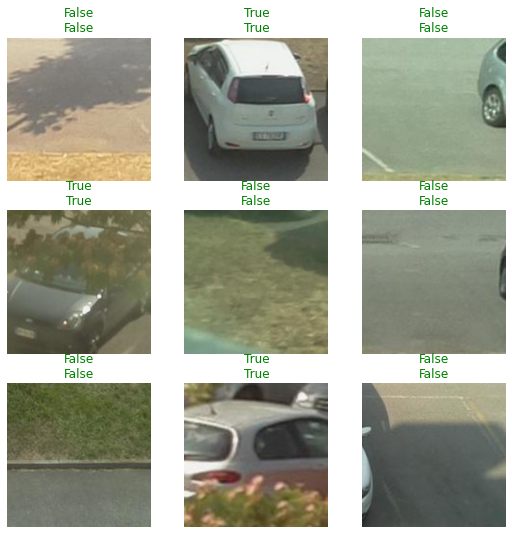

In [3]:
%cd CNRPark_data/

# occupied parking spot images are named as '#_busy_########_####_##.jpg'
def has_car(x): return x[2] == 'b'

# train classifier
dls = ImageDataLoaders.from_name_func(path='.', fnames=get_image_files('.'), 
                                      label_func=has_car, valid_pct=0.2, seed=11,
                                      item_tfms=Resize(224))

learn = cnn_learner(dls, resnet101, metrics=accuracy)
learn.fine_tune(1)
learn.show_results()

In [4]:
%cd ..

/content


In [5]:
import yaml
import numpy as np
import cv2

In [6]:
# img: image of a parking slot
# returns true if it is occupied, false otherwise
def run_classifier(img):
    learn.precompute = False 
    pred = learn.predict(img)[0]
    if pred == 'False':
        return False
    else:
        return True

In [7]:
# BEFORE PROCEEDING: upload test_video.mp4 and test_video_yml.yml
fn = "test_video.mp4"
fn_yaml = "test_video.yml"
fn_out = "test_video_result.avi"

dict = {
    'text_overlay': True,
    'parking_overlay': True,
    'show_ids': True,  # shows id on each region
    'start_frame': 0,  # begin frame from specific frame number
    'vid_total_time': 58} # total duration of test video

# Set from video
cap = cv2.VideoCapture(fn)
video_info = {'fps': cap.get(cv2.CAP_PROP_FPS),
              'width': int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) * 0.6),
              'height': int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) * 0.6),
              'fourcc': cap.get(cv2.CAP_PROP_FOURCC),
              'num_frames': int(cap.get(cv2.CAP_PROP_FRAME_COUNT))}

cap.set(cv2.CAP_PROP_POS_FRAMES, dict['start_frame'])  # jump to frame number specified

True

In [8]:
# Read YAML data (parking space polygons)
with open(fn_yaml, 'r') as stream:
    parking_data = yaml.load(stream)

parking_bounding_rects = []
if parking_data is not None:
    for park in parking_data:
        points = np.array(park['points'])
        rect = cv2.boundingRect(points)
        parking_bounding_rects.append(rect)
    spot_occupied = [False] * len(parking_data) # F = free; T = occupied

def print_parkIDs(park, coor_points, frame_rev):
    moments = cv2.moments(coor_points)
    centroid = (int(moments['m10']/moments['m00'])-3, int(moments['m01']/moments['m00'])+3)
    # putting numbers on marked regions
    cv2.putText(frame_rev, str(park['id']), (centroid[0]+1, centroid[1]+1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
    cv2.putText(frame_rev, str(park['id']), (centroid[0]-1, centroid[1]-1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
    cv2.putText(frame_rev, str(park['id']), (centroid[0]+1, centroid[1]-1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
    cv2.putText(frame_rev, str(park['id']), (centroid[0]-1, centroid[1]+1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
    cv2.putText(frame_rev, str(park['id']), centroid, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)

In [9]:
!mkdir videos
!mkdir videos/frames
!ls

CNRPark_data		     sample_data     test_video.yml
CNRPark-Patches-150x150.zip  test_video.mp4  videos


In [ ]:
# run classifier on frames every 5 second
five_sec_frame = round(5 * (video_info['num_frames'] / dict['vid_total_time'])) 

# process each frame
while cap.isOpened():
    # current position of the video file in seconds
    video_cur_pos = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0
    # index of the frame to be captured
    video_cur_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)  
    ret, frame_initial = cap.read()
    
    if ret:
        frame = cv2.resize(frame_initial, None, fx=0.6, fy=0.6)
        frame_out = frame.copy()
    else:
        print("Video ended")
        break

    # drawing text overlay at the left corner of screen
    if dict['text_overlay']:
        str_on_frame = "%d/%d" % (video_cur_frame, video_info['num_frames'])
        cv2.putText(frame_out, str_on_frame, (5, 30), cv2.FONT_HERSHEY_SIMPLEX,
                    0.8, (0, 255, 255), 2, cv2.LINE_AA)
   
    # changing the color on the basis on status change occurred in the above section
    # and putting numbers on areas
    if dict['parking_overlay'] and ((video_cur_frame == dict['start_frame']) or 
                                    (video_cur_frame == video_info['num_frames'] - 1) 
                                    or (video_cur_frame % five_sec_frame == 0)):
        for ind, park in enumerate(parking_data):
            rect = parking_bounding_rects[ind]
            roi = frame[rect[1]:(rect[1] + rect[3]),
                     rect[0]:(rect[0] + rect[2])]  # crop roi for faster calcluation
            res = run_classifier(roi) 
            if res == False:
                spot_occupied[ind] = False
            else:
                spot_occupied[ind] = True          
    
    for ind, park in enumerate(parking_data):
        if spot_occupied[ind] == False:
            color = (0, 255, 0)
        else:
            color = (0, 0, 255)

        points = np.array(park['points'])
        cv2.drawContours(frame_out, [points], contourIdx=-1,
                             color=color, thickness=2, lineType=cv2.LINE_8)
        if dict['show_ids']:
            print_parkIDs(park, points, frame_out)

    cv2.imwrite('./videos/frames/%d.jpg' % video_cur_frame, frame_out)

cap.release()

In [11]:
import os
import glob

In [12]:
ROOT_DIR = os.getcwd()
VIDEO_DIR = os.path.join(ROOT_DIR, "videos")
VIDEO_SAVE_DIR = os.path.join(VIDEO_DIR, "frames")
images = list(glob.iglob(os.path.join(VIDEO_SAVE_DIR, '*.*')))
# sort the images by integer index
images = sorted(images, key=lambda x: float(os.path.split(x)[1][:-3]))
outvid = os.path.join(VIDEO_DIR, "out.mp4")

In [13]:
def make_video(outvid, images=images, fps=30, size=None,
               is_color=True, format="FMP4"):
    """
    create a video from a list of images
 
    @param      outvid      output video
    @param      images      list of images to use in the video
    @param      fps         frame per second
    @param      size        size of each frame
    @param      is_color    color
    @param      format      see http://www.fourcc.org/codecs.php
    @return                 see http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
 
    The function is based on http://opencv-python-tutroals.readthedocs.org/en/latest/.
    By default, the video will have the size of the first image.
    It will resize every image to this size before adding them to the video.
    """
    from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
    fourcc = VideoWriter_fourcc(*format)
    vid = None
    for image in images:
        if not os.path.exists(image):
            raise FileNotFoundError(image)
        img = imread(image)
        if vid is None:
            if size is None:
                size = img.shape[1], img.shape[0]
            vid = VideoWriter(outvid, fourcc, float(fps), size, is_color)
        if size[0] != img.shape[1] and size[1] != img.shape[0]:
            img = resize(img, size)
        vid.write(img)
    vid.release()
    return vid

In [ ]:
make_video(outvid, images, fps=30)